# Overview

1. Given a star at REFO of known coordinates, astrometrically solve for the center of the MOSFIRE imaging FoV and calculate the distance and angle on the sky between the two points.
1. Subtract out the angle of the rotator (on the sky) to determine the distance (angle on the sky) and rotation (angle on instrument) between the two points.
1. Given a number of these measurements, fit the relationship between telescope elevation, rotator physical angle, and the 2D separation of the guider and instrument FoV.
1. Translate the differences to a motion of the guider (REFO) relative to the main instrument in units of guider pixels.

## Observing Procedure

1. OA: Pick a pointing star near desired EL.
1. OA: Choose rotator position angle (PA) near rotator drive angle -360.
1. OA: Slew to star using PO REF (rotator mode should be PositionAngle).
1. OA: Center star on REF using Ca, Ce adjustments ("adjust pointing") and begin guiding.
1. SA: Image field in Y-band (to minimize DAR).
1. OA: Rotate 45 degrees (rotator mode should be PositionAngle).
1. OA: Center star on REF using Ca, Ce adjustments ("adjust pointing") and begin guiding.
1. SA: Image field in Y-band.
1. Keep repeating steps 7-10 until you have rotated 360 degrees.
1. Then repeat for a new EL.

## Derived Quantities

From the image data, we derive:
1. the Measured Sky Angle: PA (East of North) between guider and instrument FoV.
1. the Physical Angle: The Angle between them after the instrument PA has been subtracted off.  This should be constant other than flexure.
1. the Separation: distance (in arcsec) between the two FoVs.  This should be constant other than flexure.


**Note:** At science field PA=0 (North Up), the guider is North of the science field by ~403 arcsec (6.7 arcmin).

In [40]:
from pathlib import Path

import ccdproc
from ccdproc import ImageFileCollection

from astropy.table import QTable, Column
from astropy import coordinates as c
from astropy import units as u
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [123]:
# table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults.txt').expanduser()
# table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults_20190515UT_t0.txt').expanduser()
# table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults_20190515UT_t2.txt').expanduser()
# table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults_20190516UT_t0.txt').expanduser()
# table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults_20190516UT_t2.txt').expanduser()
table_file = Path('~/KeckData/MOSFIRE_GuiderFlexure/ImageResults_combined_t2.txt').expanduser()


t = QTable.read(table_file, format='ascii.ecsv')

# Convert offset distance and offset angle to differential X, Y movements in the guider image plane
x = [entry['OffsetDistance'] * np.sin(entry['OffsetAngle']*np.pi/180) for entry in t]
y = [entry['OffsetDistance'] * np.cos(entry['OffsetAngle']*np.pi/180) for entry in t]

x -= np.mean(x)
y -= np.mean(y)

t.add_column(Column(x, name='Xoffset'))
t.add_column(Column(y, name='Yoffset'))

mxra = max(t['RotAng'])
mnra = min(t['RotAng'])

In [158]:
# Filter
t = t[t['EL'] > 30]

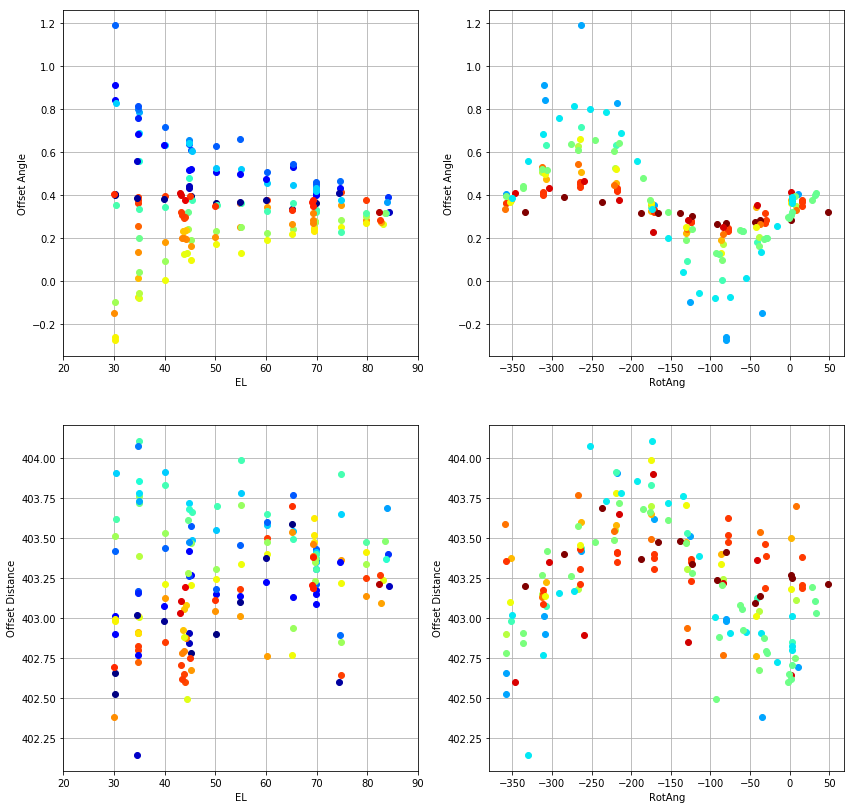

In [164]:
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
for entry in t:
    plt.plot(entry['EL'], entry['OffsetAngle'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Offset Angle')
plt.xlim(20,90)
plt.grid()

plt.subplot(2,2,2)
for entry in t:
    plt.plot(entry['RotAng'], entry['OffsetAngle'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Offset Angle')
#plt.xlim(0,360)
plt.grid()

plt.subplot(2,2,3)
for entry in t:
    plt.plot(entry['EL'], entry['OffsetDistance'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Offset Distance')
plt.xlim(20,90)
plt.grid()

plt.subplot(2,2,4)
for entry in t:
    plt.plot(entry['RotAng'], entry['OffsetDistance'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Offset Distance')
#plt.xlim(0,360)
plt.grid()

plt.show()
# plt.savefig(table_file.name.replace('.txt', '.png'), bbox_inches='tight', pad_inches=0.10)

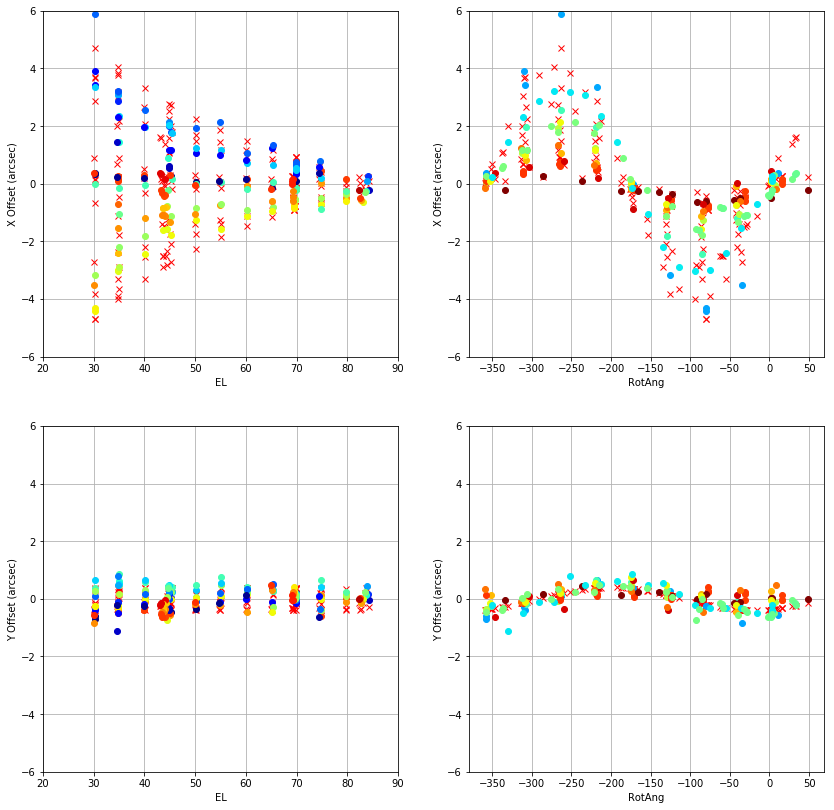

In [185]:
xoff_model = 1.2*np.sinh((180-2*t['EL'])*np.pi/180) * np.sin(t['RotAng']*np.pi/180)
yoff_model = 0.4*np.cos((t['RotAng']-160)*np.pi/180)

minoff = min( [min(t['Xoffset']), min(t['Yoffset'])] )
maxoff = max( [max(t['Xoffset']), max(t['Yoffset'])] )
offlim = np.ceil(max( [abs(minoff), maxoff] ))

plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.plot(t['EL'], xoff_model, 'rx')
for i,entry in enumerate(t):
    plt.plot(entry['EL'], entry['Xoffset'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('X Offset (arcsec)')
plt.xlim(20,90)
plt.ylim(-offlim,offlim)
plt.grid()

plt.subplot(2,2,2)
plt.plot(t['RotAng'], xoff_model, 'rx')
for i,entry in enumerate(t):
    plt.plot(entry['RotAng'], entry['Xoffset'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('X Offset (arcsec)')
plt.ylim(-offlim,offlim)
plt.grid()

plt.subplot(2,2,3)
plt.plot(t['EL'], yoff_model, 'rx')
for i,entry in enumerate(t):
    plt.plot(entry['EL'], entry['Yoffset'], 'ko', color=cm.jet( (entry['RotAng']-mnra)/(mxra-mnra) ))
plt.xlabel('EL')
plt.ylabel('Y Offset (arcsec)')
plt.xlim(20,90)
plt.ylim(-offlim,offlim)
plt.grid()

plt.subplot(2,2,4)
plt.plot(t['RotAng'], yoff_model, 'rx')
for i,entry in enumerate(t):
    plt.plot(entry['RotAng'], entry['Yoffset'], 'ko', color=cm.jet( (entry['EL']-10)/70 ))
plt.xlabel('RotAng')
plt.ylabel('Y Offset (arcsec)')
plt.ylim(-offlim,offlim)
plt.grid()

plt.show()

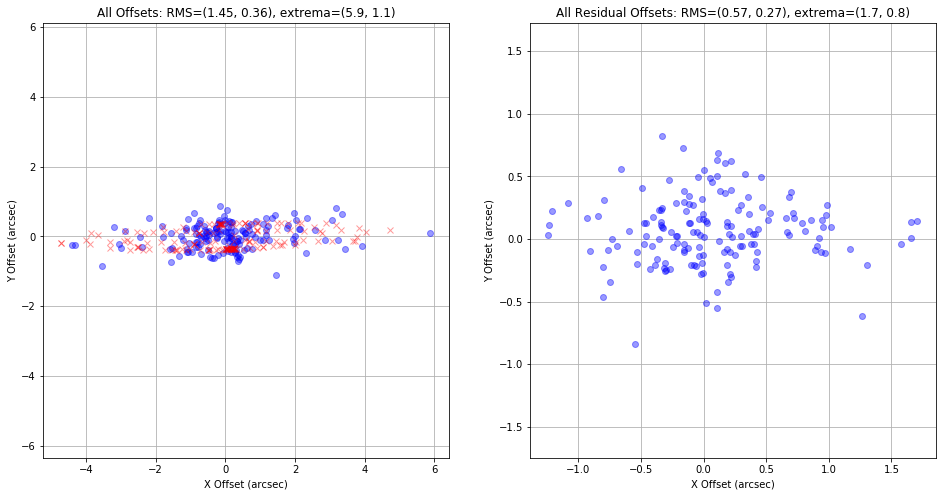

In [184]:
rms = (np.sqrt(np.mean(t['Xoffset']**2)), np.sqrt(np.mean(t['Yoffset']**2)))
extrema = ( max(abs(t['Xoffset'])), max(abs(t['Yoffset'])) )

rms_residuals = (np.sqrt(np.mean((t['Xoffset']-xoff_model)**2)), np.sqrt(np.mean((t['Yoffset']-yoff_model)**2)))
extrema_residuals = ( max(abs(t['Xoffset']-xoff_model)), max(abs(t['Yoffset']-yoff_model)) )

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title(f'All Offsets: RMS=({rms[0]:.2f}, {rms[1]:.2f}), extrema=({extrema[0]:.1f}, {extrema[1]:.1f})')
plt.plot(t['Xoffset'], t['Yoffset'], 'bo', alpha=0.4)
plt.plot(xoff_model, yoff_model, 'rx', alpha=0.4)
plt.xlabel('X Offset (arcsec)')
plt.ylabel('Y Offset (arcsec)')
plt.gca().axis('equal')
plt.grid()

plt.subplot(1,2,2)
plt.title(f'All Residual Offsets: RMS=({rms_residuals[0]:.2f}, {rms_residuals[1]:.2f}), extrema=({extrema_residuals[0]:.1f}, {extrema_residuals[1]:.1f})')
plt.plot(t['Xoffset']-xoff_model, t['Yoffset']-yoff_model, 'bo', alpha=0.4)
plt.xlabel('X Offset (arcsec)')
plt.ylabel('Y Offset (arcsec)')
plt.gca().axis('equal')
plt.grid()

plt.show()

In [120]:
from sklearn.decomposition import PCA